# TP 2: Résolution d'équations non linéaires
## PHY-3500: Physique numérique (H2021) - 5 mars 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import sympy as sym
import pandas as pd
import timeit

## Le potentiel de Lennard-Jones

### Question 1

On cherche à exprimer les points de rebroussement en fonction de l'énergie $\epsilon_n$. On sait qu'il existe deux points de rebroussement, notés $r_-$ et $r_+$, et qu'ils correspondent aux positions où l'impulsion est nulle (positions où les noyaux changent de direction). L'impulsion linéaire local $p(r)$ est donnée par

$$ p(r)=\pm\left[2 \mu(E_n - V(r))\right]^{1 / 2}. $$

En utilisant les variables sans dimension suivantes

$$ \epsilon_n = \frac{E_n}{V_{0}} \quad, \quad x=\frac{r}{\sigma} \quad, \quad \gamma=\left(\frac{2 \mu \sigma^{2} V_{0}}{\hbar^{2}}\right)^{1 / 2}, $$

il est possible d'écrire l'impulsion linéaire local sous la forme

$$ p(x)=\pm\left[2 \mu V_0 (\epsilon_n - v(x))\right]^{1 / 2}, $$

où on a

$$ v(x)=4\left[\left(\frac{1}{x}\right)^{12}-\left(\frac{1}{x}\right)^{6}\right]. $$

Les points de rebroussement $x_-$ et $x_+$ sont donc déterminés par l'équation $ p(x) = 0 $, soit

$$
p(x) = \pm\left[2 \mu V_0 \left(\epsilon_n - 4\left[\left(\frac{1}{x}\right)^{12}-\left(\frac{1}{x}\right)^{6}\right]\right)\right]^{1 / 2} = 0, \\
\implies \epsilon_n = 4\left[\left(\frac{1}{x}\right)^{12}-\left(\frac{1}{x}\right)^{6}\right], \\
\implies \frac{\epsilon_n}{4}x^{12}  + x^6 - 1 = 0. \\
$$

En utilisant la substitution $y = x^6$, on a que

$$
\frac{\epsilon_n}{4}y^{2}  + y - 1 = 0,
$$

ce qui nous donne les solutions suivantes en utilisant la formule quadratique :

$$
y = \frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n} \quad \text{et} \\
y = -\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n},
$$

avec $\epsilon_n \neq 0$. Si $\epsilon_n = 0$, on a que $y = 1$, mais le cas $\epsilon_n = 0$ n'est pas intéressant puisqu'il signifie que l'énergie $E = 0$. En revenant à une solution avec $x$, on a que

$$
x_- = \left[\frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n}\right]^{1/6} \quad \text{et} \\
x_+ = \left[-\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n}\right]^{1/6}.
$$

Il est important de noter que l'on désire obtenir des solutions réelles et positives pour les valeurs de $x_-$ et $x_+$ et on ne considère donc pas les racines complexes. On doit s'assurer que notre choix de $x_-$ et $x_+$ fait en sorte que $x_+ > x_-$. Pour ce faire, on doit d'abord déterminer le domaine de la valeur de $\epsilon_n$, soit si $\epsilon_n$ est un nombre positif ou négatif dans notre problème. On remarque que le point de rebroussement $x_+$ est un nombre réel pour $\epsilon_n < 0$ et un nombre complexe pour $\epsilon_n > 0$. On se doute donc que $\epsilon_n$ doit être négatif. Comme confirmation, on peut observer la courbe du potentiel réalisée par le bloc de code suivant.

In [2]:
def get_dimensionless_potential(x):
    """
    Getter du potentiel adimensionnel de Lennard-Jones.
    
    Parameters
    ----------
    x: Position adimensionnelle. (float)
    
    Returns
    -------
    Potentiel adimensionnel (float)
    """
    return 4*(x**-12 - x**-6)

def show_dimensionless_potential():
    """
    Réalise la figure du potentiel adimensionnel en fonction la position adimensionnelle.
    """
    x = np.linspace(0.93, 2, 1000)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    line, = ax.plot(x, get_dimensionless_potential(x), color='k', lw=2)
    ax.set_title("Potentiel adimensionnel de Lennard-Jones", fontsize=14)

    ax.set_xlabel("Position adimensionnelle $x$ [-]", fontsize=14)
    ax.set_xlim()
    ax.set_ylabel("Potentiel adimensionnel $v(x)$ [-]", fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

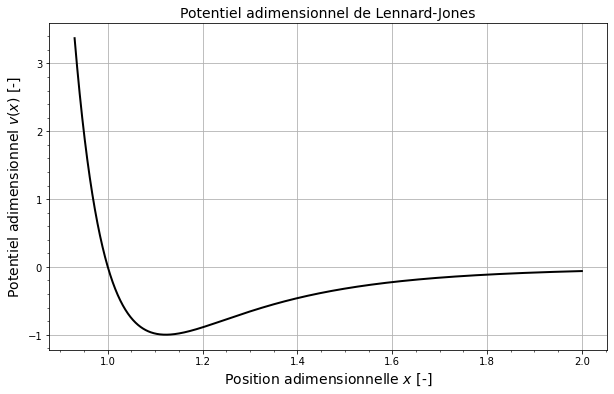

In [3]:
show_dimensionless_potential()

On remarque donc que le potentiel $v(x)$ est contraint de $[-1, 0[$ pour tout $x > 1$. Comme les points de rebroussement sont déterminés par l'équation $p(x) = 0$ donc $\epsilon_n = v(x)$, on a que 

$$ \epsilon_n \in [-1, 0[. $$

On doit maintenant s'assurer que notre choix de $x_-$ et $x_+$ fait en sorte que $x_+ > x_-$ sur ce domaine. Le bloc de code suivant permet d'observer les positions des points de rebroussement $x_-$ et $x_+$ obtenues en fonction du paramètre $\epsilon_n$.

In [4]:
def get_xmin(eps):
    """
    Getter du point de rebroussement inférieur.
    
    Parameters
    ----------
    eps: Énergie adimensionnelle. (float)
    
    Returns
    -------
    Position adimensionnelle (float)
    """
    return (2*((eps + 1)**(1/2) - 1)/eps)**(1/6)

def get_xmax(eps):
    """
    Getter du point de rebroussement supérieure.
    
    Parameters
    ----------
    eps: Énergie adimensionnelle. (float)
    
    Returns
    -------
    Position adimensionnelle (float)
    """
    return (-2*((eps + 1)**(1/2) + 1)/eps)**(1/6)

def show_turning_points():
    """
    Réalise la figure des points de rebroussement en fonction de l'énergie adimensionnelle.
    """
    eps = np.linspace(-1, -0.01, 1000)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    line1, = ax.plot(eps, get_xmin(eps), color='b', lw=2, label="Point de rebroussement $x_-$")
    line2, = ax.plot(eps, get_xmax(eps), color='r', lw=2, label="Point de rebroussement $x_+$")
    ax.set_title("Position adimensionnel des points de rebroussement en fonction de l'énergie", fontsize=14)

    ax.set_xlabel("Énergie adimensionnelle $\epsilon_n$ [-]", fontsize=14)
    ax.set_xlim()
    ax.set_ylabel("Position adimensionnel $x$ [-]", fontsize=14)
    ax.minorticks_on()
    ax.legend(fontsize=14)

    plt.grid()
    plt.show()
    plt.close(fig)

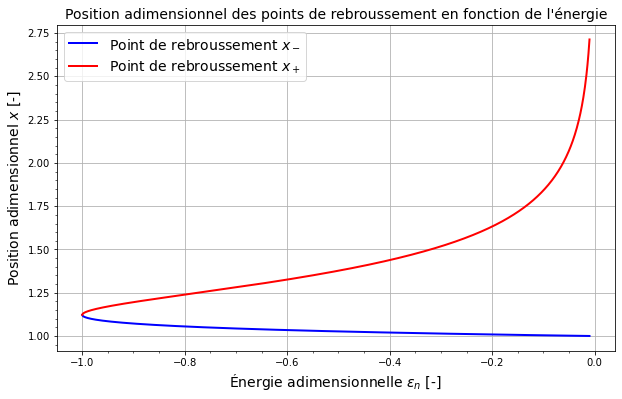

In [5]:
show_turning_points()

Notre choix de $x_-$ et $x_+$ fait bien en sorte que $x_+ > x_-$ sur le domaine de validité de $\epsilon_n$. La solution finale pour les points de rebroussement en fonction de $\epsilon_n$ est donc
$$
x_-(\epsilon_n) = \left[\frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n}\right]^{1/6} \quad \text{et} \quad x_+(\epsilon_n) = \left[-\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n}\right]^{1/6},
$$
ou plutôt
$$
r_-(\epsilon_n) = \sigma\left[\frac{2\left((\epsilon_n + 1)^{1/2} - 1\right)}{\epsilon_n}\right]^{1/6} \quad \text{et} \quad r_+(\epsilon_n) = \sigma\left[-\frac{2\left((\epsilon_n + 1)^{1/2} + 1\right)}{\epsilon_n}\right]^{1/6}.
$$


### Note
1.0/1.0

### Question 2

On cherche à écrire une fonction qui retournera la valeur de l'énergie adimensionnelle $\epsilon$ en fonction des paramètres $\gamma$ et $n$. On choisit de définir cette fonction sous forme d'une méthode de bissection générale, qui fonctionnera non seulement pour une fonction de $\epsilon$, $\gamma$ et $n$, mais pour toute fonction, et ce, en utilisant l'argument **func_kwargs.

In [6]:
def bissection(func, a, b, error_target, show_convergence: bool = False, **func_kwargs):
    """
    Implémentation d'une méthode de bissection.
    
    Parameters
    ----------
    func: Fonction dont la valeur en abscisse du zéro doit être déterminée. (function)
    a: Borne inférieure pour l'initialisation de la méthode de bissection. (float)
    b: Borne supérieure pour l'initialisation de la méthode de bissection. (float)
    error_target: Valeur de l'erreur à atteindre. (float)
    show_convergence: Affichage du graphique de convergence de l'algorithme. (bool)
    **func_kwargs:
        gamma: Valeur du paramètre gamma. (float)
        n: État considéré. (float)
        
    Returns
    -------
    Valeur en abscisse à laquelle la fonction est nulle. (float)
    """
    f_a = func(a, **func_kwargs)
    f_b = func(b, **func_kwargs)
    assert f_a*f_b <= 0, "La fonction évaluée aux deux points choisis sont de même signe"

    err = np.inf
    mid_values: list = []
    while err > error_target:
        mid = 1/2*(a + b)
        mid_values.append(mid)
        f_a = func(a, **func_kwargs)
        f_b = func(b, **func_kwargs)
        f_mid = func(mid, **func_kwargs)

        if f_a * f_mid < 0:
            b = mid
            a = a
        
        elif f_b * f_mid < 0:
            a = mid
            b = b
            
        elif mid == 0:
            print("Found the exact solution")
            return mid
        
        else:
            return None
        
        err = abs(b - a)
    
    error_values = abs(np.array(mid_values) - mid_values[-1])[:-1]
    
    if show_convergence:
        iterations = list(range(len(error_values)))
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)

        line1, = ax.plot(iterations, error_values, color='k', lw=2)
        ax.set_yscale('log')
        ax.set_title(f"Convergence de la méthode de la bissection", fontsize=14)
        ax.set_xlabel("Nombre d'itération [-]", fontsize=14)
        ax.set_xlim()
        ax.set_ylabel("Erreur relative [-]", fontsize=14)
        ax.minorticks_on()

        plt.grid()
        plt.show()
        plt.close(fig)

    return mid


### Commentaires
1. Jolie généralisation du concept
2. Quelques noms de variables très... court. `a -> lower_bound`, `b -> upper_bound` serait un peu plus facile à lire et à suivre au lieu de devoir toujours retourner au docstring pour se rapeller lequel est lequel

### Note
2.0/2.0

### Question 3

On désire déterminer l'énergie des 20 premiers états vibrationnels de la molécule $O_2$. On définit d'abord une fonction qui sera égale à 0 lorsque la valeur en abscisse sera $\epsilon$, soit l'énergie correspondant à l'état vibrationnel. Pour ce faire, on utilise l'équation (9) présentée dans le document TP2 et on soustrait le côté gauche par le côté droit. On a donc que la fonction *get_quasi_classical_action* retourne la valeur $V$ suivante :

$$ V = \gamma \left(\int_{x_{-}}^{x_{+}}\left[\epsilon_{n}-v(x)\right]^{1 / 2} d x \right) - (n+1 / 2) \pi $$

Il est important de noter que l'intégration est réalisée avec *scipy.integrate.quad*.

In [7]:
def get_quasi_classical_action(eps, gamma, n):
    """
    Getter de la valeur du potentiel d'action évaluée avec epsilon soustraint à la valeur évaluée avec n.
    
    Parameters
    ----------
    eps: Énergie adimensionnelle. (float)
    gamma: Mesure de la nature quantique du système. (float)
    n: État vibrationnel. (float)
        
    Returns
    -------
    Valeur du potentiel d'action évaluée avec epsilon soustraint à la valeur évaluée avec n.
    """
    assert eps < 0 and eps > -1, r"Attention! Le domaine de validité de l'énergie adimensionnelle est [-1 < epsilon < 0]"
    
    x_min: float = get_xmin(eps)
    x_max: float = get_xmax(eps)
    
    integrand = lambda x, eps: (eps - get_dimensionless_potential(x))**(1/2)
    
    action: float = integrate.quad(func=integrand, a=x_min, b=x_max, args=(eps,))[0]
    
    return gamma*action - (n + 1/2)*np.pi


On doit évaluer l'énergie des 20 premiers états vibrationnels. On utilise donc la fonction de bissection développéee à la question 2 et on l'applique à la fonction précédente. On détermine aussi les points de rebroussement et le potentiel adimensionnel et on regroupe le tout dans un tableau.

In [8]:
gamma_O2: float = 150
nb_state: float = 20
n_states: list = list(range(nb_state))

eps_1 = -0.99 
eps_2 = -0.01

states_title = "États vibrationels [-]"
dimensionless_energy_title = "Énergie adimensionnelle [-]"
x_min_title = "Point de rebroussement inférieur [-]"
x_max_title = "Point de rebroussement supérieur [-]"
dimensionless_potential_title = "Potentiel adimensionnel [-]"

columns = [states_title, dimensionless_energy_title, x_min_title, x_max_title, dimensionless_potential_title]
results = pd.DataFrame(columns=columns)

for n in n_states:
    dimensionless_energy = bissection(func=get_quasi_classical_action, 
                                      a=eps_1, 
                                      b=eps_2, 
                                      error_target=10**-8, 
                                      gamma=gamma_O2, 
                                      n=n
                                     )
    
    x_min = get_xmin(dimensionless_energy)
    x_max = get_xmax(dimensionless_energy)
    potential = get_dimensionless_potential(x=x_min)
    
    units = {
        states_title: f"{n:.0f}",
        dimensionless_energy_title: dimensionless_energy,
        x_min_title: x_min,
        x_max_title: x_max,
        dimensionless_potential_title: potential
    }
    
    results = results.append(units, ignore_index=True, )

pd.options.display.float_format = "{:,.8f}".format
display(results)


,États vibrationels [-],Énergie adimensionnelle [-],Point de rebroussement inférieur [-],Point de rebroussement supérieur [-],Potentiel adimensionnel [-]
0,0,-0.96476413,1.09073638,1.16203714,-0.96476413
1,1,-0.89667159,1.07151113,1.19740503,-0.89667159
2,2,-0.83170344,1.05996009,1.22572319,-0.83170344
3,3,-0.76980149,1.05148960,1.25162787,-0.76980149
4,4,-0.71090663,1.04478666,1.27647884,-0.71090663
5,5,-0.65495877,1.03925911,1.30091972,-0.65495877
6,6,-0.60189681,1.03458149,1.32533282,-0.60189681
7,7,-0.55165867,1.03055300,1.34998184,-0.55165867
8,8,-0.50418121,1.02703982,1.37507042,-0.50418121
9,9,-0.45940020,1.02394772,1.40077059,-0.45940020


### Commentaires
1. J'aime bien l'utilisation de typecast ici, cependant la convention veut en générale qu'un float ne soit pas définit comme un int. Les variables `gamma_O2`, et `nb_state` seraient probablement mieux en ints. De plus est-ce que un float fait vraiment du sens pour "number of states"? Sinon au minimum quelque chose du genre `nb_state: float = 20.` ou le point force le type float.

(Oui il y a des raisons pourquoi ceci fonctionne quand même, je parle simplement ici de conventions)

Le tableau précédent montre que l'énergie adimensionnelle augmente avec le numéro de l'état vibrationnel. Cette observation est conforme à la théorie puisqu'on s'attend à ce que la molécule soit dans un état énergétique plus élevé pour un nombre $n$ plus grand. Aussi, on remarque que les colonnes d'énergie adimensionnelle et de potentiel adimensionnel contiennent les mêmes valeurs, ce qui signifie bien que l'énergie des différents états semble suivre la courbe de Lennard-Jones. En effet, le potentiel est calculé directement à partir de la position des points de rebroussement trouvés et correspond donc à une certaine hauteur sur la courbe de Lennard-Jones.


On cherche maintenant à tracer l'énergie potentiel des différents états. On superpose évidemment les énergies au potentiel de Lennard-Jones.

In [9]:
def show_energy():
    """
    Réalise la figure du potentiel adimensionnelle des différents états considérés en fonction de la postion 
    adimensionnelle.
    """
    x = np.linspace(0.98, 2, 1000)
    
    nb_state: float = 20
    n_states: list = list(range(nb_state))
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    line1, = ax.plot(x, get_dimensionless_potential(x), color='k', lw=2)
    
    for n in n_states:
        row_n = results.loc[results[states_title] == str(n)]
        x_min = row_n[x_min_title].item()
        x_max = row_n[x_max_title].item()
        dimensionless_potential = row_n[dimensionless_potential_title].item()
        line2, = ax.plot([x_min, x_max], [dimensionless_potential]*2, lw=2, label=f"État {n:.0f}", marker='.', 
                         markersize=10)
    
    ax.set_title(f"Potentiel adimensionnel de Lennard-Jones avec les différentes \n énergies \
pour {n_states[-1] + 1:.0f} états", fontsize=14)
    ax.set_xlabel("Position adimensionnelle $x$ [-]", fontsize=14)
    ax.set_xlim()
    ax.set_ylabel("Potentiel adimensionnel $v(x)$ [-]", fontsize=14)
    ax.minorticks_on()
    ax.legend()

    plt.grid()
    plt.show()
    plt.close(fig)


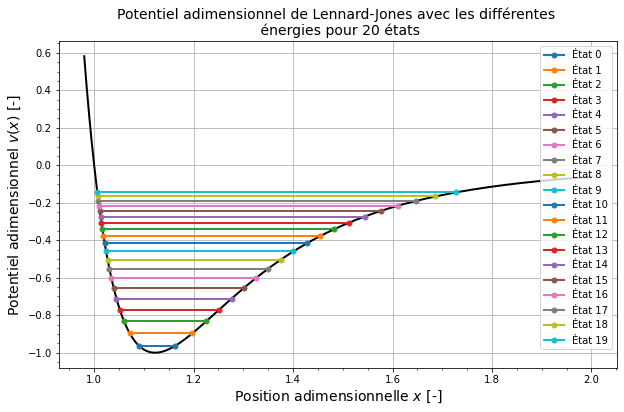

In [10]:
show_energy()

On remarque que plus le numéro de l'état augmente, plus l'énergie potentielle augmente de même ce qui concorde avec ce qui était attendue et avec les observations précédentes. Par ailleurs, on remarque que les points de rebroussement pour un certain état correspond bien aux intersections entre la droite horizontale et la courbe du potentiel adimensionnel de Lennard-Jones. On peut donc conclure que la molécule $O_2$ se prête effectivement très bien à une modélisation par le potentiel de Lennard-Jones.

### Commentaires
1. Le graphique pourait être un peu "zoomed", notament `plt.ylim(0., -1.1)`. Oui la tendence des deux bord peut-être intéréssante, mais le graphique cherche à démontrer les niveaux. Tel que présenté ici ils sont un peu difficile à voire.
2. Très bonne explication et démo des résultats obtenus.

### Note
2.0/2.0

### Question 4

On doit maintenant définir une méthode de la sécante d'une façon semblable à celle de la bissection afin de comparer leur temps d'exécution et leur convergence.

In [11]:
def secant(func, a, b, error_target, show_convergence: bool = False, **func_kwargs):
    """
    Implémentation d'une méthode de la sécante.
    
    Parameters
    ----------
    func: Fonction dont la valeur en abscisse du zéro doit être déterminée. (function)
    a: Borne inférieure pour l'initialisation de la méthode de bissection. (float)
    b: Borne supérieure pour l'initialisation de la méthode de bissection. (float)
    error_target: Valeur de l'erreur à atteindre. (float)
    show_convergence: Affichage du graphique de convergence de l'algorithme. (bool)
    **func_kwargs:
        gamma: Valeur du paramètre gamma. (float)
        n: État considéré. (float)
        
    Returns
    -------
    Valeur en abscisse à laquelle la fonction est nulle. (float)
    """
    
    f_a = func(a, **func_kwargs)

    err = np.inf
    mid_values: list = []
    while err > error_target:        
        f_a = func(a, **func_kwargs)
        f_b = func(b, **func_kwargs)

        mid = b - f_b*(b - a)/(f_b - f_a)
        mid_values.append(mid)
        a = b
        b = mid

        err = abs(b - a)
    
    error_values = abs(np.array(mid_values) - mid_values[-1])[:-1]
    
    if show_convergence:
        iterations = list(range(len(error_values)))
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)

        line1, = ax.plot(iterations, error_values, color='k', lw=2)
        ax.set_yscale('log')
        ax.set_title(f"Convergence de la méthode de la sécante", fontsize=14)
        ax.set_xlabel("Nombre d'itération [-]", fontsize=14)
        ax.set_xlim()
        ax.set_ylabel("Erreur relative [-]", fontsize=14)
        ax.minorticks_on()

        plt.grid()
        plt.show()
        plt.close(fig)

    return mid

On peut maintenant comparer la convergence des deux méthodes et leur temps d'exécution. Afin de visualiser adéquatement la convergence, on trace l'erreur relative entre les valeurs obtenues à chaque itération en fonction du nombre d'itération réalisée. L'axe de l'erreur relative est choisi comme étant logarithmique puisque cela permet de visualiser plus facilement les décroissances linéaires vs non-linéaires.

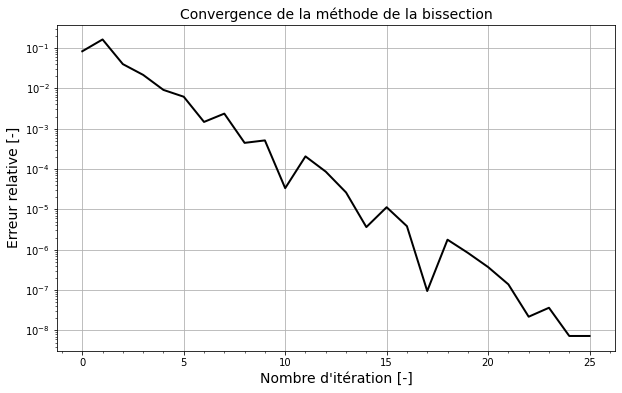

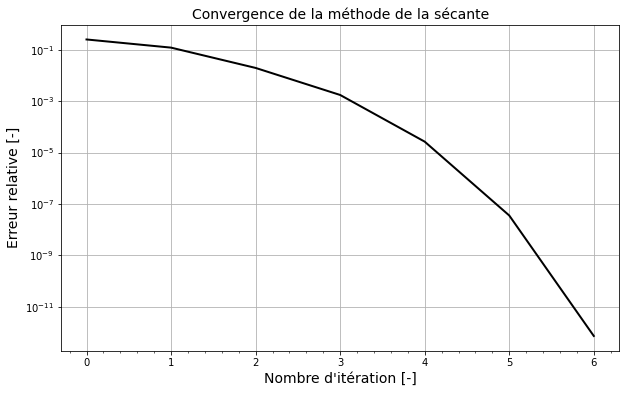

La valeur obtenue avec la méthode de bissection est -0.41725035
La valeur obtenue avec la métode de la sécante est -0.41725034
Temps de convergence de la méthode de bissection =  0.02730060000000023 s
Temps de convergence de la méthode de la sécante =  0.005263300000001081 s


In [12]:
gamma_O2: float = 150
n_state: float = 10
eps_1 = -0.99
eps_2 = -0.01

bissection_value = bissection(func=get_quasi_classical_action, 
                              a=eps_1, 
                              b=eps_2, 
                              error_target=10**-8, 
                              show_convergence=True, 
                              gamma=gamma_O2, 
                              n=n_state
                             )

secant_value = secant(func=get_quasi_classical_action, 
                      a=eps_1, 
                      b=eps_2, 
                      error_target=10**-8, 
                      show_convergence=True, 
                      gamma=gamma_O2, 
                      n=n_state
                     )

print(f"La valeur obtenue avec la méthode de bissection est {bissection_value:.8f}")
print(f"La valeur obtenue avec la métode de la sécante est {secant_value:.8f}")

starttime = timeit.default_timer()
bissection_time = bissection(func=get_quasi_classical_action, 
                              a=eps_1, 
                              b=eps_2, 
                              error_target=10**-8, 
                              show_convergence=False, 
                              gamma=gamma_O2, 
                              n=n_state
                             )

print("Temps de convergence de la méthode de bissection = ", timeit.default_timer()-starttime, "s")


starttime = timeit.default_timer()
secant_time = secant(func=get_quasi_classical_action, 
                      a=eps_1, 
                      b=eps_2, 
                      error_target=10**-8, 
                      show_convergence=False, 
                      gamma=gamma_O2, 
                      n=n_state
                     )

print("Temps de convergence de la méthode de la sécante = ", timeit.default_timer()-starttime, "s")

On remarque sur le premier graphique que la méthode de bissection a bel et bien une convergence linéaire alors que la méthode de la sécante a une convergence qui semble quadratique. En réalité, le taux de convergence de la méthode de la sécante n'est pas quadratique, il est plutôt superlinéaire et égale au nombre d'or, soit environ 1.618.

Par ailleurs, au niveau des temps de convergence, on remarque que la méthode de la sécante est beaucoup plus rapide que la méthode de bissection dans cet exemple. Ce résultat est logique puisque le taux de convergence de la méthode de la sécante est plus grand et elle effectue donc un nombre plus faible d'itérations pour converger vers la même valeur. Cette rapidité peut entre autres s'expliquer par le fait que la méthode de la sécante ne change pas constamment le signe de la fonction qui est évaluée. En d'autres mots, elle converge d'un seule côté du zéro plutôt que d'effectuer des aller-retours entre la gauche et la droite du zéro tel la méthode de bissection et elle semble donc être une méthode plus stable et donc plus rapide.

### Commentaires
1. Il est discuter ici du taux de convergence, mais il n'y a rien de démontré. Je ne vois pas de tracé quadratique ou avec un taux de 1.618(?). Est-ce que ce chiffre est sortit de nulle part ou est-ce qu'il y a une explication pour ceci? (-0.25)
2. Lorsque vous travaillez avec des valleurs comme 0.027 et 0.00526, pensez à changez vos unitées. Dans ce cas ms au lieu de s.
3. Bonne comparaison entre les deux fonctions.

### Note
2.75/3.0

## Pandémie et relaxation

### Question 5

Dans cette section, un algorithme de relaxation pour l'équation du pourcentage de la population infecté en termes
de la pandémie en fonction du nombre de reproduction de base est réalisé.

In [13]:
def pop_percentage(R0):
    """
    Calcule le pourcentage de la population infecté en termes de la pandémie.
    
    Parameters
    ----------
    R0: Nombre de reproduction de base de la pandémie. (float)
    
    Returns
    -------
    p (float), prec (float), p_list(list)  
    """
    p_list = []
    p  = 0.5
    p_prev = p
    p  = 1-np.exp(-R0 * p)
    prec = abs(p-p_prev)
    
    p_list.append(p)
    
    
    while prec >= 0.000001:
        p_prev = p
        p  = 1-np.exp(-R0 * p)
        p_list.append(p)
        prec = abs(p-p_prev)
   
        
    return (p,prec,p_list)

Dans cette section, la fonction fait à la section précédente est utilisée afin d'évaluer la population infecté
selon plusieurs nombre de reproduction de base pour finalement en tracer un graphique.

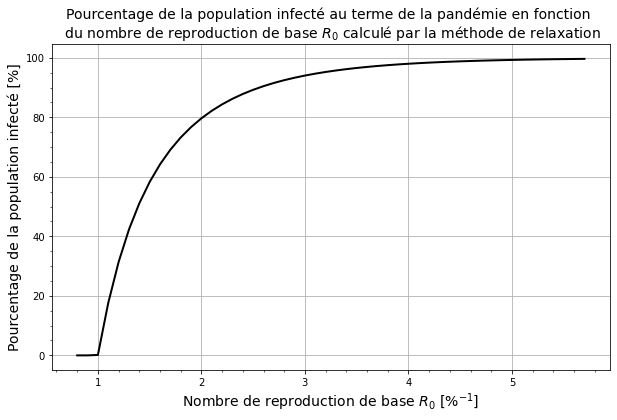

moyenne de la précision pour chacun des R0 =  4.874866091175712e-07 %


In [14]:
min_R0 = 0.8
max_R0 = 5.7
step = 0.1

def plot_pop_percentage_R0(min_R0,max_R0,step):
    """
    Évalue le pourcentage de population infecté pour une plage de nombre de reproduction de base
    et trace le graphique correspondant.
    
    Parameters
    ----------
    min_R0: valeur du nombre de reproduction de base minimal à évaluer [%$^{-1}$] (float)
    max_R0: valeur du nombre de reproduction de base maximal à évaluer [%$^{-1}$] (float)
    step: valeur des incréments à tester pour l'intervalle défini par les deux autres paramètres. (float)

    Returns
    -------
    prec_moy (float)
    None
    """
    R0_vec = np.arange(min_R0,max_R0+step,step)
    pop = []
    prec = []
    for R0 in R0_vec:
        p = pop_percentage(R0)[0]
        prec.append(pop_percentage(R0)[1])
        pop.append(p)
        
    pop = 100*np.asarray(pop)    
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(R0_vec, pop, color='k', lw=2)
    ax.set_title("Pourcentage de la population infecté au terme de la pandémie en fonction \n"
                 " du nombre de reproduction de base $R_{0}$ calculé par la méthode de relaxation", fontsize=14)

    ax.set_xlabel("Nombre de reproduction de base $R_{0}$ [%$^{-1}$]", fontsize=14)
    ax.set_xlim()
    ax.set_ylabel("Pourcentage de la population infecté [%]", fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)
    
    prec_moy = np.mean(prec)
    
    return prec_moy
    
    
prec = plot_pop_percentage_R0(min_R0,max_R0,step)

print("moyenne de la précision pour chacun des R0 = ",prec, "%")



On prédit donc que le COVID-19 infecterait entre 0% et 100% de la population ce qui est à la fois inquiétant et rassurant. On remarque aussi que la transition de p = 0 à p > 0 est à 1 ce qui est attendu à cause que l'équation prend la forme 
$$
p = 1-e^{-R_0p}.
$$


#### Commentaire

1. Le code est bien commenté. N'hésitez pas de commenter dans les fonctions, pas seulement au *header*.

2. Beau graphique!

3. Bonne réponse. Merci pour commenter le résultat :) 

4. Utiliser la formule de l'erreur sur l'estimé! (-0.3)

#### Note

1.7/2.0

## Pandémie et relaxation accélérée

### Question 6

Il faut démontrer que l'erreur sur l'estimé $x'$ est donné par

\begin{align}
\tag{1}
\epsilon^{\prime}=\frac{x-x^{\prime}}{1-\frac{1}{(1+\omega) f^{\prime}(x)-\omega}}.
\end{align}

Pour ce faire, l'équation (6.81) tirée du Newman 

\begin{align}
\tag{2}
\epsilon^{\prime}=\epsilon f'(x^*)
\end{align}

est utilisée. Donc, on sait que

\begin{align}
\tag{3}
x^*= x + \epsilon
\end{align}

où $x^*$ est la solution de l'équation à solutionner. Ainsi, en remplaçant (2) dans (3), on obtient

\begin{align}
\tag{4}
x^*= x+\frac{\epsilon^{\prime}}{f^{\prime}\left(x^{*}\right)}.
\end{align}

De plus, on sait aussi, naturellement, que

\begin{align}
\tag{5}
x^*= x' + \epsilon'.
\end{align}

Alors, en remplaçant (5) dans (4), on obtient

\begin{align}
\tag{6}
x'+ \epsilon'= x +\frac{\epsilon^{\prime}}{f^{\prime}\left(x^{*}\right)}.
\end{align}

Il est ensuite possible de réarranger l'expression (6) de la manière suivante pour arriver à l'expression (6.83) du Newman. Tout d'abord, en regroupant les termes en $\epsilon'$,

\begin{align}
\epsilon' - \frac{\epsilon^{\prime}}{f^{\prime}\left(x^{*}\right)}= x - x',
\end{align}

ensuite, en faisant une mise en évidence simple,

\begin{align}
\epsilon' (1 - \frac{1}{f^{\prime}\left(x^{*}\right)})= x - x'
\end{align}

et finalement, en isolant $\epsilon$',

\begin{align}
\tag{7}
\epsilon' = \frac{x - x'}{(1 - \frac{1}{f^{\prime}\left(x^{*}\right)})}.
\end{align}

Afin de terminer la démonstration, il faut trouver l'expression de $f^{\prime}\left(x^{*}\right)$. Dans l'énoncée de la question 6, on dit que f(x) = x' et que 

\begin{align}
x' = (1+\omega) f(x)-\omega x
\end{align}

ce qui peut être dérivé pour obtenir

\begin{align}
\tag{8}
f'(x) = (1+\omega) f^{\prime}(x)-\omega.
\end{align}

On conclu alors la démonstration en remplaçant l'équation (8) dans l'équation (7) ce qui donne l'expression (1) qui est de

\begin{align}
\tag{1}
\epsilon^{\prime}=\frac{x-x^{\prime}}{1-\frac{1}{(1+\omega) f^{\prime}(x)-\omega}}.
\end{align}

si la valeur de x est près de $x^*$ ce qui permet de poser que $f^{\prime}(x)$ $\simeq$ $f^{\prime}(x^*)$. CQFD

#### Commentaire

1. Excellent!

#### Note

1.0/1.0

### Question 7

Dans cette section, l'algorithme réalisé à la question 5 est utilisé pour trouver le nombre d'itérations nécessaire à la convergence pour un $R_0$ de 2.

In [15]:
(p,prec,p_list) = pop_percentage(2)
print("Le nombre d'itérations nécessaire à la convergence est de", len(p_list), "pour avoir" 
      "une précision d'au moins 10^{-6}.")

Le nombre d'itérations nécessaire à la convergence est de 16 pour avoirune précision d'au moins 10^{-6}.


#### Commentaires

1. Utiliser la formule de l'erreur sur l'estimé! (-0.2)

#### Note

0.8/1.0

### Question 8 

Dans cette section, l'algorithme réalisé à la section 5 est refait pour faire usage de la méthode de relaxation accélérée.

In [16]:
def acc_pop_percentage(R0, omega):
    """
    Calcule le pourcentage de la population infecté en termes de la pandémie avec la méthode de relaxation accélérée.
    
    Parameters
    ----------
    R0: Nombre de reproduction de base de la pandémie. (float)
    omega: paramètre d'accélération de la relaxation. (float)
    
    Returns
    -------
    p (float), prec (float), p_list(list)  
    """
    p_list = []
    p  = 0.5
    p_prev = p
    
    p  = 1-np.exp(-R0 * p)
    
    p_next = (1+omega)*p-(omega*p_prev)
    
    prec = abs(p-p_prev)
    
    p_list.append(p)
    
    
    while prec >= 0.000001:
        
        p_prev = p
        
        p  = 1-np.exp(-R0 * p_next)
        
        p_next = (1+omega)*p-(omega*p_next)
        
        p_list.append(p)
        
        prec = abs(p-p_prev)
        
    return (p,prec,p_list)

Dans cette section l'algorithme de la section précédente est utilisé pour optimiser la valeur de $\omega$ de la méthode de relaxation accéléré pour un $R_0$ de 2.

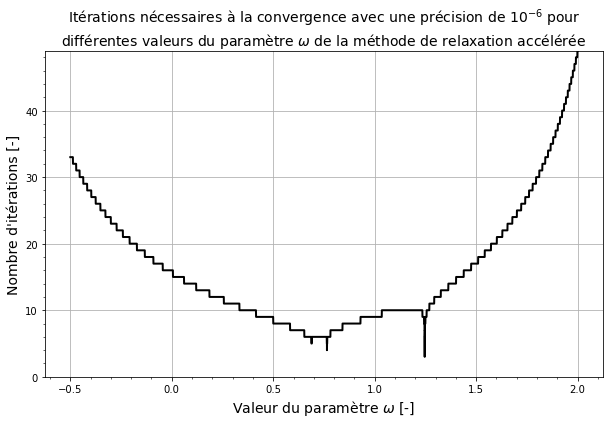

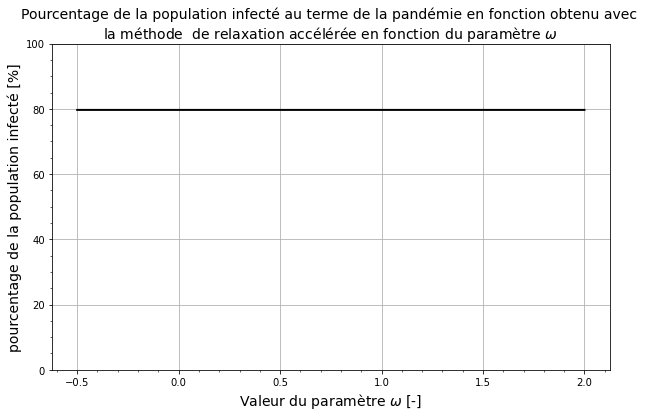

Moyenne de la précision pour chacun des omega testés =  6.178315095170576e-07
Valeur(s) de omega optimale(s) trouvée(s) = [1.24652 1.24653] pour obtenir un nombre d'itérations minimal de 3 .


In [17]:
def plot_acc_pop_percentage_w(R0, min_omega,max_omega,step):
    """
    Évalue le pourcentage de population infecté pour une plage du paramètre omega de la méthode de relaxation accélérée
    et trace un graphique du nombre d'itérations nécessaire à la convergence permettant d'optimiser la résolution 
    de l'équation avec le paramètre omega.
    
    Parameters
    ----------
    R0: valeur du nombre de reproduction de base à évaluer [%$^{-1}$] (float)
    min_omega: valeur du paramètre omega minimal à évaluer [-] (float)
    max_omega: valeur du paramètre omega maximal à évaluer [-] (float)
    step: valeur des incréments à tester pour l'intervalle défini par les deux autres valeurs de omega. (float)

    Returns
    -------
    prec_moy (float), min_it (int), optimized_omega (float)
    """
    omega_vec = np.arange(min_omega,max_omega+step,step)
    pop = []
    prec = []
    it = []
    for omega in omega_vec:
        
        (p,precis,p_list) = acc_pop_percentage(2,omega)
        
        prec.append(precis)
        it.append(len(p_list))
        pop.append(p)
        
    pop = np.asarray(pop)
        
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(omega_vec, it, color='k', lw=2)
    ax.set_title("Itérations nécessaires à la convergence avec une précision de $10^{-6}$ pour \n" 
                 
                 "différentes valeurs du paramètre $\omega$ de la méthode de relaxation accélérée", fontsize=14)

    ax.set_xlabel("Valeur du paramètre $\omega$ [-]", fontsize=14)
    ax.set_xlim()
    ax.set_ylim(0,max(it))
    ax.set_ylabel("Nombre d'itérations [-]", fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(omega_vec, pop*100, color='k', lw=2)
    ax.set_title("Pourcentage de la population infecté au terme de la pandémie en fonction obtenu avec \n"
                 "la méthode  de relaxation accélérée en fonction du paramètre $\omega$", fontsize=14)

    ax.set_xlabel("Valeur du paramètre $\omega$ [-]", fontsize=14)
    ax.set_xlim()
    ax.set_ylim(0,100)
    ax.set_ylabel("pourcentage de la population infecté [%]", fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)
    
    pop = np.asarray(pop)
    
    prec_moy = np.mean(prec)
    
    it_arr = np.asarray(it)
    
    it_min = np.where(it_arr == min(it_arr))
    
    optimized_omega = omega_vec[it_min]
    
    min_it = min(it_arr)
        
        
    return prec_moy, min_it, optimized_omega

min_omega = -0.5
max_omega = 2
step = 0.00001    
    
prec, min_it, omega = plot_acc_pop_percentage_w(2,min_omega,max_omega,step)

print("Moyenne de la précision pour chacun des omega testés = ",prec)
print("Valeur(s) de omega optimale(s) trouvée(s) =", omega, "pour obtenir un nombre d'itérations minimal de", min_it,".")

Donc, la relaxation accélérée permet bien de converger plus rapidement vers une solution tout en donnant une solution valide au problème. On note aussi que les valeurs de $\omega$ optimales obtenus sont directement dépendantes de la valeur de initiale testée dans l'algorithme. Ainsi, si on venant changer cette valeur qui est présentement de 0.5 à 0.75, par exemple, les valeurs de $\omega$ changeraient. De plus, en utilisant un $\omega$ de 1.24652 ou 1.24653 on vient accélérer la convergence de la méthode de relaxation de près d'un facteur 4.

#### Commentaires

1. Good job!

2. Les résultats sont bien rapportés.

#### Note

2.0/2.0

### Question 9

Oui, certaines équations pourraient converger plus rapidement avec un paramètre $\omega$ négatif. Par exemple, dans le cas où $\omega$ $\simeq$ -1 avec la fonction précédente où on utilise un $R_0$ de 2. Cela nous donne une autre solution pour l'équation, mais celle-ci converge en 2 itérations seulement ce qui est plus rapide que le total de 3 itérations obtenu précédemment avec des valeurs de $\omega$ positives. Toutefois, cette autre solution est seulement due au fait que, parce que $\omega$ prend la valeur de -1, la prochaine valeur de la variable à tester dans l'algorithme est la même que celle de l'itération précédente. N'ayant alors aucun changement dans la valeur obtenue, l'algorithme converge à cette valeur. C'est pourquoi peu importe les paramètres entrés dans l'algorithme, la résolution donnera une solution érronnée si $\omega$ $\simeq$ -1. On peut observer ce comportement à l'aide du code de la section suivante.

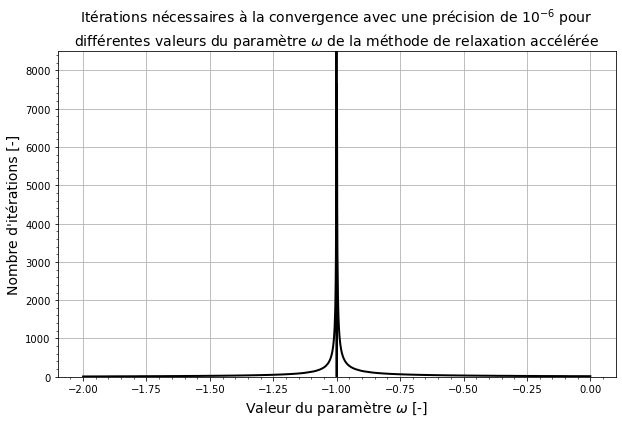

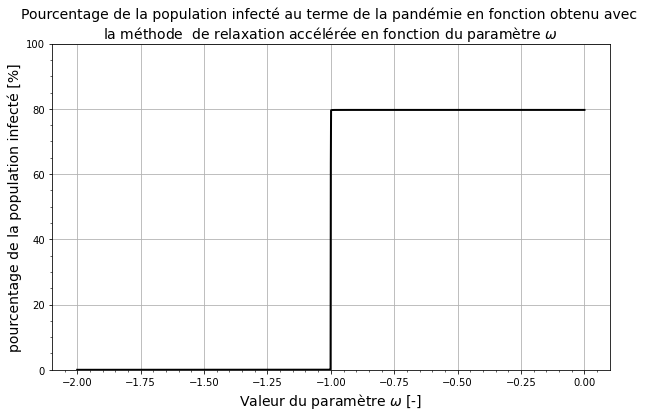

Moyenne de la précision pour chacun des omega testés =  7.641872812686842e-07
Valeur(s) de omega optimale(s) trouvée(s) = [-1.] pour obtenir un nombre d'itérations minimal de 2 .


In [18]:
min_omega = -2
max_omega = 0
step = 0.001    
    
prec, min_it, omega = plot_acc_pop_percentage_w(2,min_omega,max_omega,step)

print("Moyenne de la précision pour chacun des omega testés = ",prec)
print("Valeur(s) de omega optimale(s) trouvée(s) =", omega, "pour obtenir un nombre d'itérations minimal de", min_it,".")

Donc, l'utilisation d'un $\omega$ négatif de valeur $\simeq$ -1 donne un solution erronée tandis que des valeurs plus petites que -1 semblent donner la solution triviale de l'équation. De plus, un autre cas où utiliser un $\omega$ < 0 pourrait aider à la convergence est celui où l'algorithme tend à toujours surévaluer la valeur recherchée et donc prend plus de temps à converger. Un $\omega$ négatif dans cette situation ferait en sorte de diminuer ou même d'enlever ce dépassement ce qui rendrait la convergence plus rapide.

#### Commentaire

1. En effet, les valeurs négatives de $\omega$ sont utile quand $f'(x) <0$. La méthode de relaxation oscille d'un côté à l'autre lorsqu'il converge vers la solution. (-2.0)

2. Une fonction quelconque qui obéit cette condition aurait pu utiliser pour faire preuve de l'affirmation de l'exercice "La réponse est oui, mais pourquoi".

3. Correcte: "Un $\omega$ négatif dans cette situation ferait en sorte de diminuer ou même d'enlever ce dépassement ce qui rendrait la convergence plus rapide." (+0.5)

#### Note

0.5/2.0

# Qualité de code
1. Bonne utilisation de docstrings, mais commentaires dans les fonctions manquent
2. Utilisation seulemnt partielle de typecasting? Semble un peu curieux de ne l'avoir que ici et la.
3. Quelques noms de variables pas clairs

### Note Finale
Questions (90%), Qualité de code (10%)

Questions: 13.75/16.0    
Qualité de code: 8/10

Total: 85%